# 11강 rjags를 이용한 사후표본 추출

## 01 JASG 설치

1) JAGS를 설치한다.

http://sourceforge.net/projects/mcmc-jags/files/JAGS/3.X/.

2) R에서 rjags, coda, ggmcmc 패키지를 설치한다.

In [10]:
#install.packages("rjags")
#install.packages("coda")
#install.packages("ggmcmc")

library(rjags)
library(dplyr)
library(coda)
library(ggmcmc)

## 02 정규모형의 예

- 모형: $X_1, X_2, \cdots, X_n|\theta,\tau \overset{i.i.d}{\sim}N(\theta, \tau^{-2})$

- 사전분포
  $\theta\sim N(\theta_0, 0.0001^{-2})$
  $\sigma\sim Unif(0,M)$
  $\sigma^2=\tau^{-2}$
- $\theta_0=\bar{x}$로 M=2s로 고정시키다.  

In [3]:
# 자료의 읽기
army = read.csv("army-physical.csv", header=T, sep=",")
head(army)

,seq,date,bust,sleeve,height,waist,crotch,head,foot,weight
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,52094,2014,91.8,88.5,177.8,84.1,83.9,57.8,27.2,78.8
2,57714,2014,94.7,86.3,171.9,89.2,78.6,58.6,26.8,71.9
3,10741,20140224,114.0,89.4,179.3,109.8,84.8,60.8,29.9,105.9
4,8843,2013,105.7,88.1,177.0,94.4,77.9,57.6,28.0,81.1
5,19853,20140414,100.6,87.5,175.7,92.6,76.4,58.1,27.8,78.8
6,42241,2013,104.2,88.6,176.5,98.1,81.7,60.4,26.7,83.8


In [7]:
x = army$height
n = length(x)

# JAGS에서 모형 서술
modelstring = "
    model {
        for(i in 1:N) {
            x[i] ~ dnorm(theta, tau)
        }
        theta ~ dnorm(theta0, 0.0001)
        tau <- pow(sigma, -2)
        sigma ~ dunif(0,M)
    }
"

In [9]:
jags <- jags.model(textConnection(modelstring), data=list('x'=x, 'N'=n, 'theta0'=mean(x), M=2*sd(x)), n.chains=4, n.adapt=100)

post <- coda.samples(jags, c('theta', 'tau', 'sigma'), n.iter=2000, thin=2)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 210

Initializing model




Iterations = 102:2100
Thinning interval = 2 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean       SD  Naive SE Time-series SE
sigma   5.00348 0.257705 4.075e-03      0.0044910
tau     0.04026 0.004127 6.526e-05      0.0000715
theta 174.32813 0.349797 5.531e-03      0.0054013

2. Quantiles for each variable:

           2.5%       25%       50%       75%    97.5%
sigma   4.52676   4.82684   4.99297   5.16924   5.5456
tau     0.03252   0.03742   0.04011   0.04292   0.0488
theta 173.65058 174.09305 174.32603 174.56690 175.0033


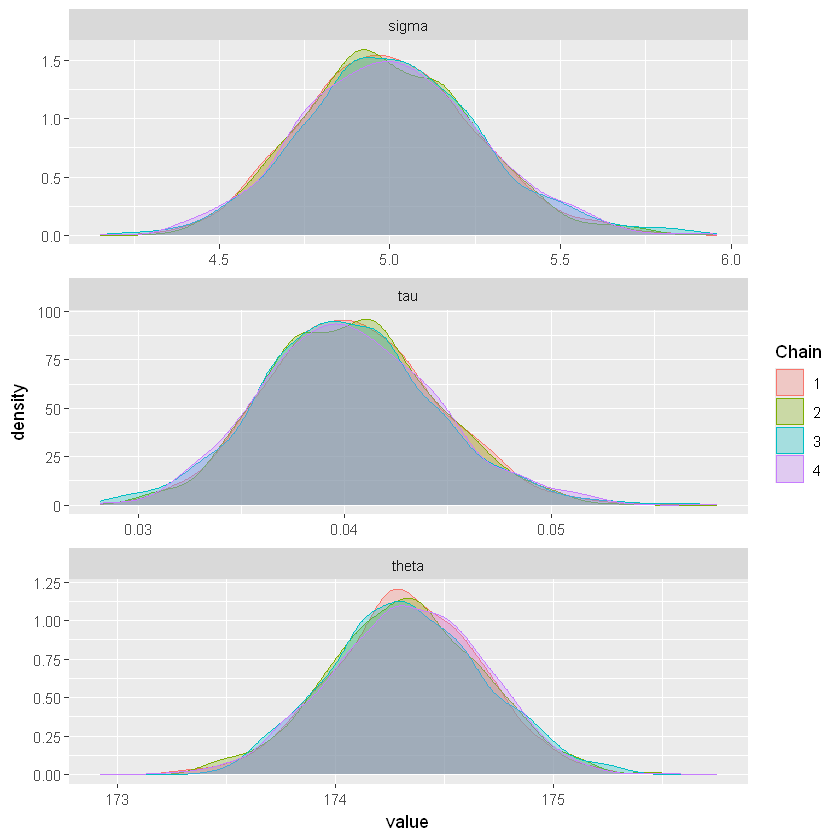

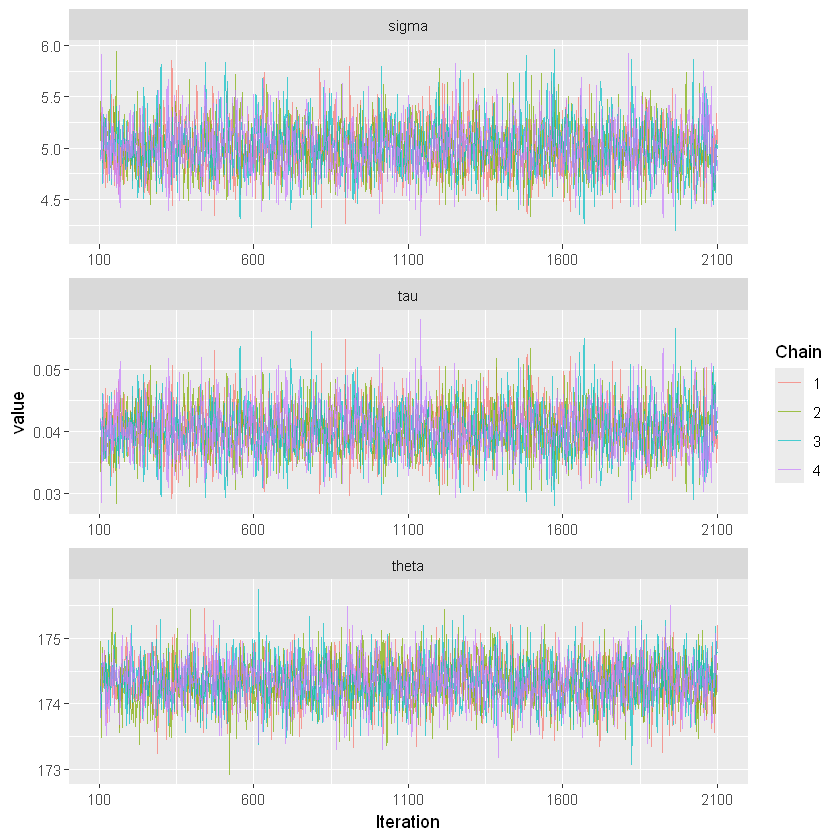

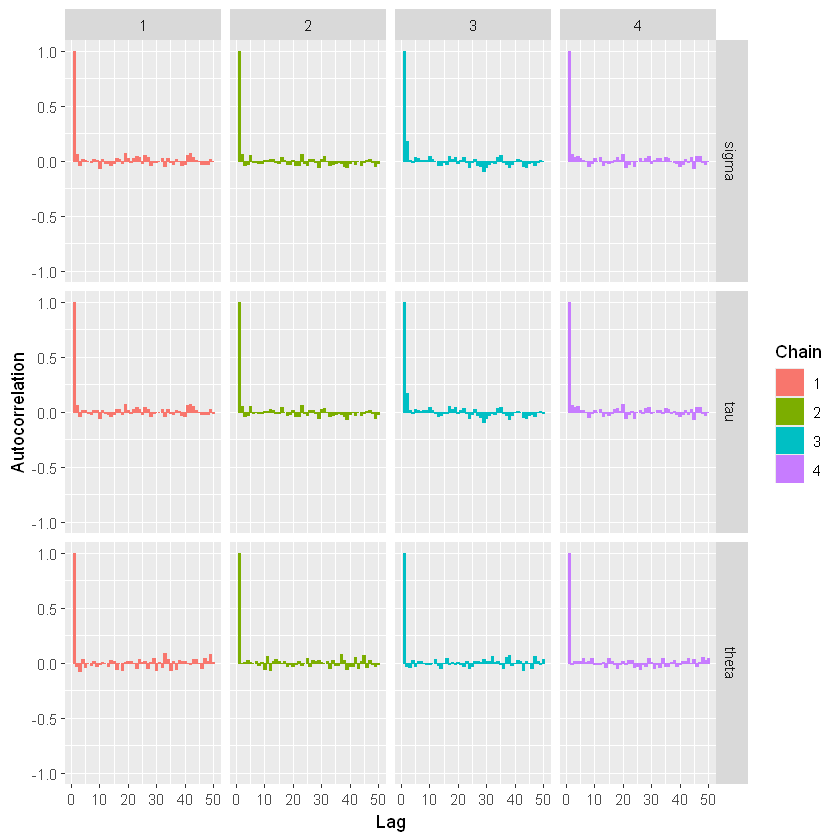

In [ ]:
summary(post)
ggs_post <- ggs(post)
ggs_density(ggs_post)
ggs_traceplot(ggs_post)
ggs_autocorrelation(ggs_post)

## 03 다변량 정규모형의 예

- 모형: $X_1, \cdots, X_N \overset{i.i.d}{\sim} N(\theta, V^{-1})$

- 사전분포
  $\theta \sim N(\mu_0, V_0^{-1})$
  $V\sim Wishart(B_0, p+1)$

In [13]:
# 자료 읽기
army = read.csv("army-physical.csv", header=T, sep=",")
head(army)

,seq,date,bust,sleeve,height,waist,crotch,head,foot,weight
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,52094,2014,91.8,88.5,177.8,84.1,83.9,57.8,27.2,78.8
2,57714,2014,94.7,86.3,171.9,89.2,78.6,58.6,26.8,71.9
3,10741,20140224,114.0,89.4,179.3,109.8,84.8,60.8,29.9,105.9
4,8843,2013,105.7,88.1,177.0,94.4,77.9,57.6,28.0,81.1
5,19853,20140414,100.6,87.5,175.7,92.6,76.4,58.1,27.8,78.8
6,42241,2013,104.2,88.6,176.5,98.1,81.7,60.4,26.7,83.8


In [ ]:
x = army[,c(5,6,10)]  # height, waist, weight
n = dim(x)[1]
p = dim(x)[2]

In [18]:
modelstring = "
    model {
        for (i in 1:n) {
            x[i, 1:p] ~ dmnorm(theta[1:p], V[1:p, 1:p])
        }
    theta[1:p] ~ dmnorm(mu0[], V0[,])
    V[1:p, 1:p] ~ dwish(B0[,], p+1)
    Sigma <- inverse(V[,])
    }
"

In [19]:
# 모델을 적합하기 위한 데이터 입력
mu0 = xbar = sapply(x, mean)
V0 = solve(cov(x))*0.001
B0 = solve(cov(x))/(p+1)

jags <- jags.model(textConnection(modelstring), data=list('x'=x, 'n'=n, 'p'=p, 'V0'=V0, 'mu0'=mu0, 'B0'=B0), n.chains = 4, n.adapt = 100)

post <- coda.samples(jags, c('theta', 'Sigma'), n.iter=2000, thin=2)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 231

Initializing model




Iterations = 2:2000
Thinning interval = 2 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean      SD Naive SE Time-series SE
Sigma[1,1]  24.708  2.5657  0.04057       0.041487
Sigma[2,1]   8.587  3.6909  0.05836       0.058372
Sigma[3,1]  23.981  4.9991  0.07904       0.079050
Sigma[1,2]   8.587  3.6909  0.05836       0.058372
Sigma[2,2] 107.642 10.8092  0.17091       0.175938
Sigma[3,2] 117.716 12.7284  0.20125       0.206308
Sigma[1,3]  23.981  4.9991  0.07904       0.079050
Sigma[2,3] 117.716 12.7284  0.20125       0.206308
Sigma[3,3] 174.494 17.2487  0.27273       0.272692
theta[1]   174.307  0.3599  0.00569       0.005689
theta[2]    86.406  0.7275  0.01150       0.011501
theta[3]    72.308  0.9358  0.01480       0.014798

2. Quantiles for each variable:

              2.5%     25%    50%    75%  97.5%
Sigma[1,1]  20.218  22.849  24.55  26.31  30.20
Sigma[2,1]   

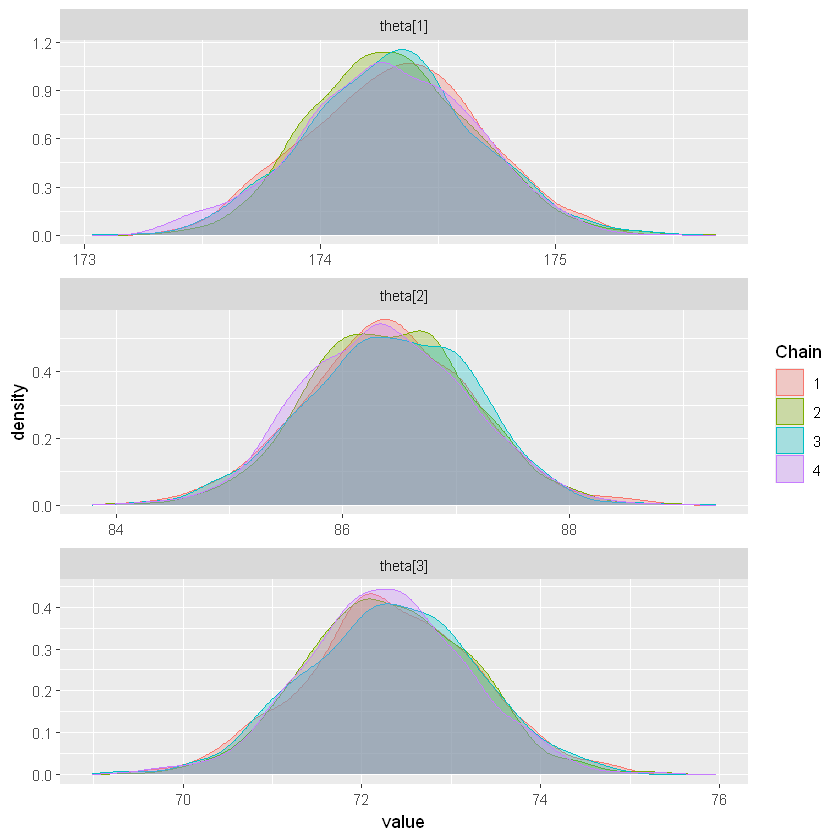

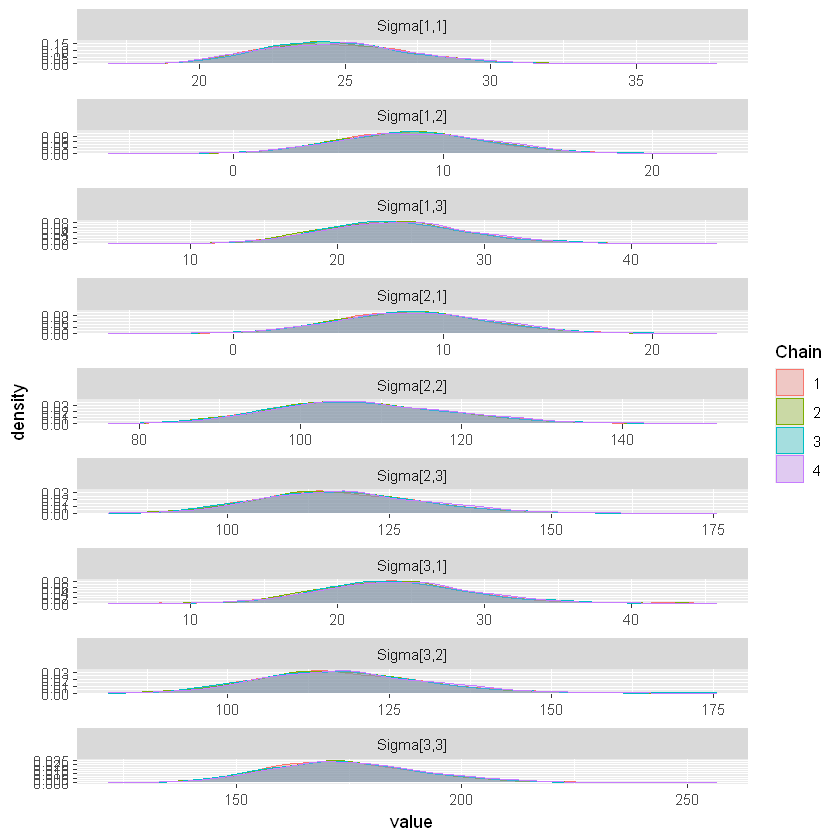

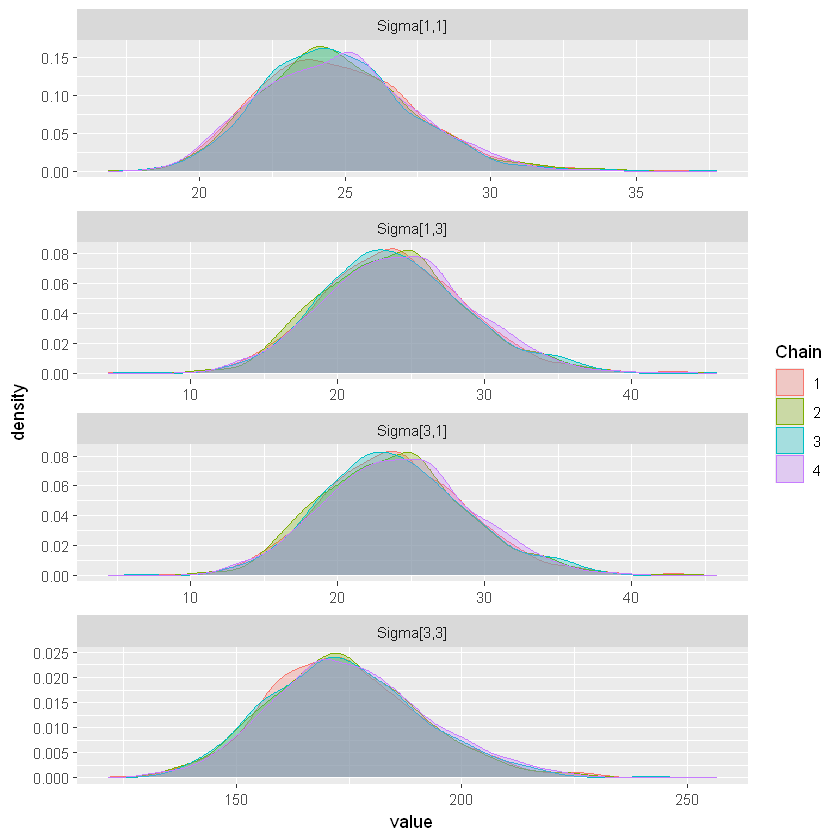

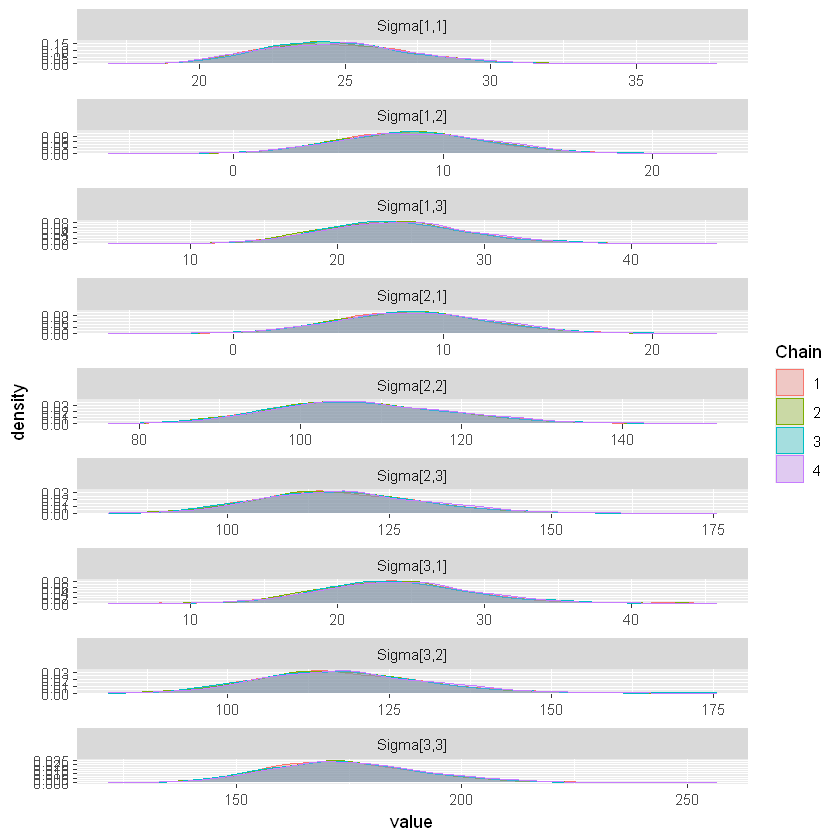

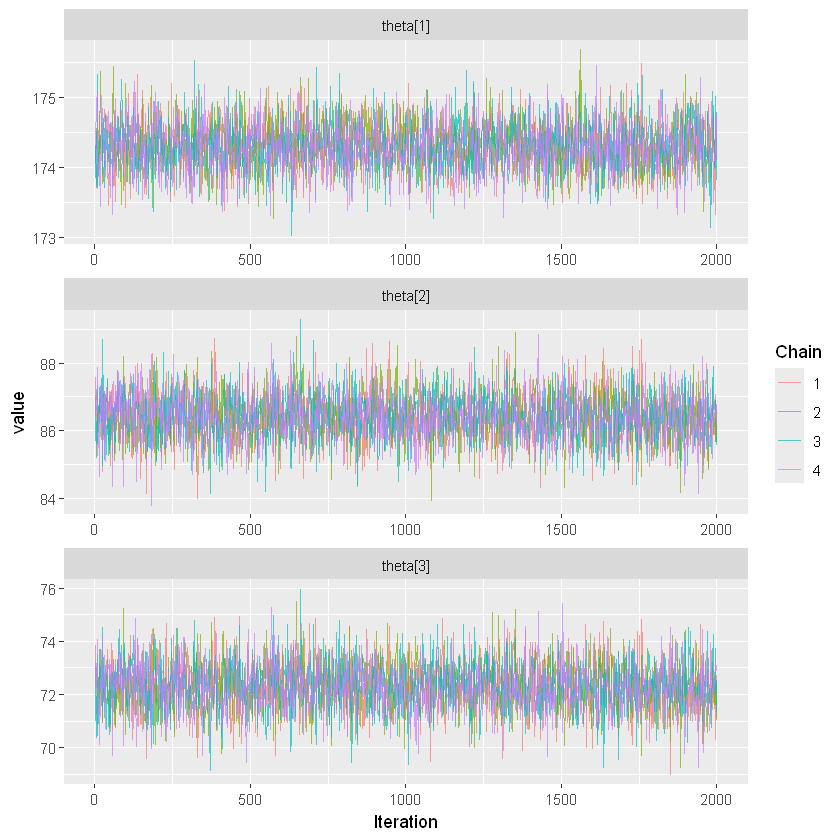

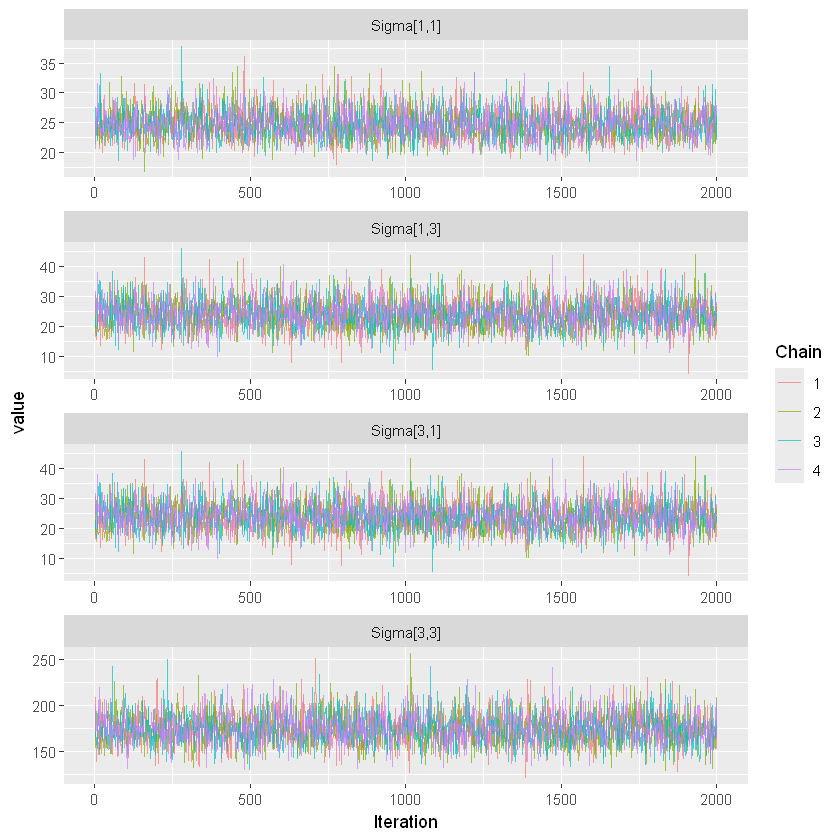

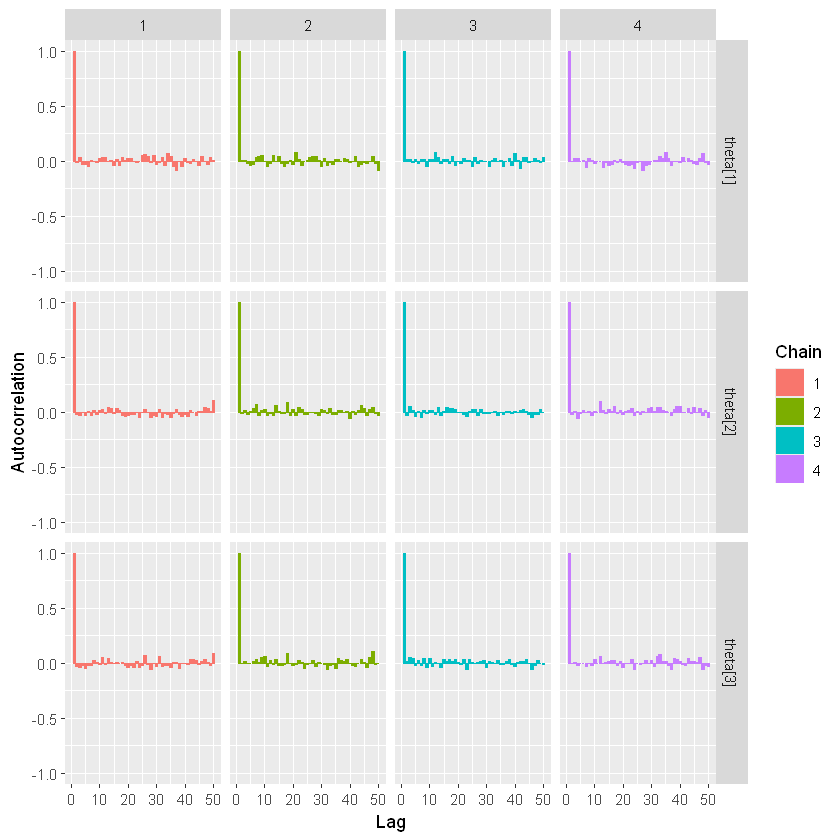

In [27]:
# 1. summary
summary(post)

# 2. ggs 변환
ggs_post <- ggs(post)

# 3. ggs_density plots
ggs_density(ggs_post, family = 'theta')
ggs_density(ggs_post, family = 'Sigma')
ggs_density(ggs_post, family = 'Sigma\\[(1|3),(1|3)\\]')
ggs_density(ggs_post, family = 'Sigma\\[[1-3],[1-3]\\]')

# 4. ggs_traceplot plots
ggs_traceplot(ggs_post, family = 'theta')
ggs_traceplot(ggs_post, family = 'Sigma\\[(1|3),(1|3)\\]')

# 5. ggs_autocorrelation plot
ggs_autocorrelation(ggs_post, family = 'theta')


Iterations = 2:2000
Thinning interval = 2 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean      SD Naive SE Time-series SE
Sigma[1,1]  24.708  2.5657  0.04057       0.041487
Sigma[2,1]   8.587  3.6909  0.05836       0.058372
Sigma[3,1]  23.981  4.9991  0.07904       0.079050
Sigma[1,2]   8.587  3.6909  0.05836       0.058372
Sigma[2,2] 107.642 10.8092  0.17091       0.175938
Sigma[3,2] 117.716 12.7284  0.20125       0.206308
Sigma[1,3]  23.981  4.9991  0.07904       0.079050
Sigma[2,3] 117.716 12.7284  0.20125       0.206308
Sigma[3,3] 174.494 17.2487  0.27273       0.272692
theta[1]   174.307  0.3599  0.00569       0.005689
theta[2]    86.406  0.7275  0.01150       0.011501
theta[3]    72.308  0.9358  0.01480       0.014798

2. Quantiles for each variable:

              2.5%     25%    50%    75%  97.5%
Sigma[1,1]  20.218  22.849  24.55  26.31  30.20
Sigma[2,1]   

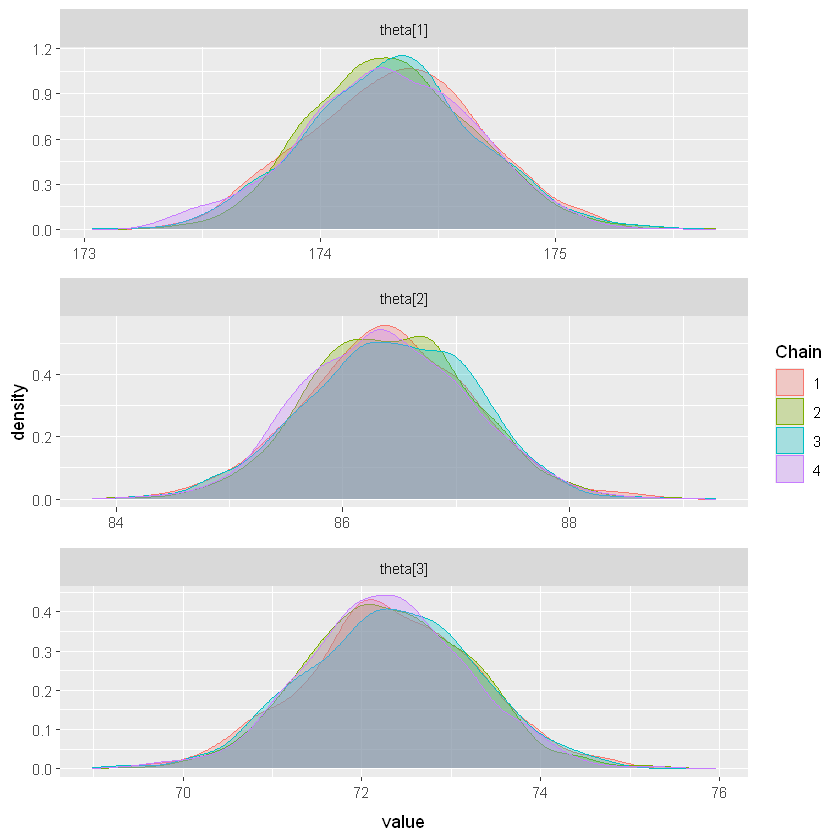

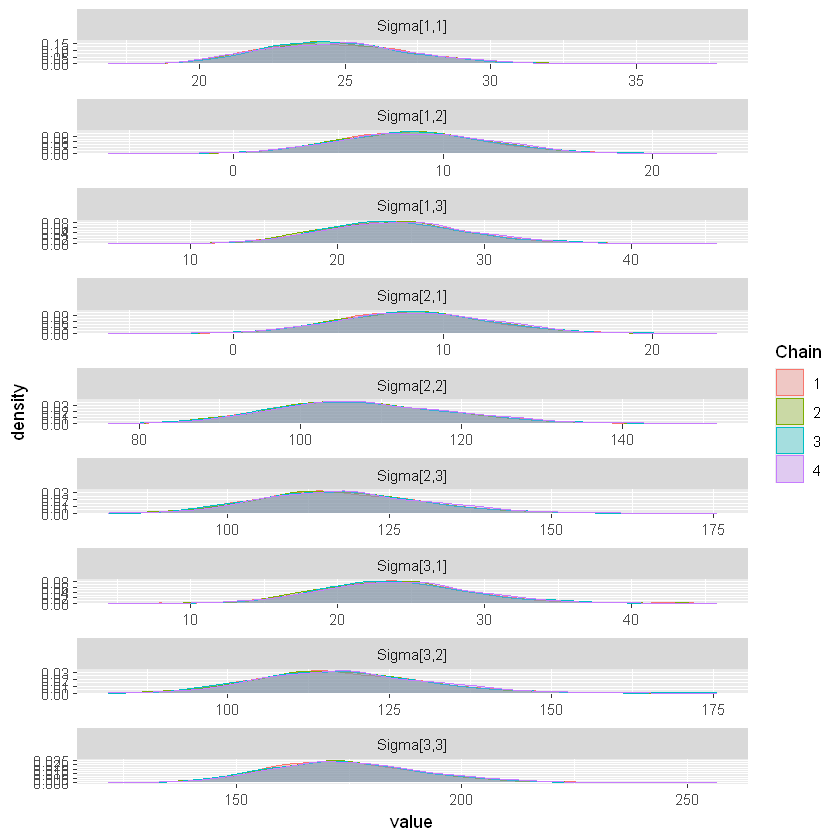

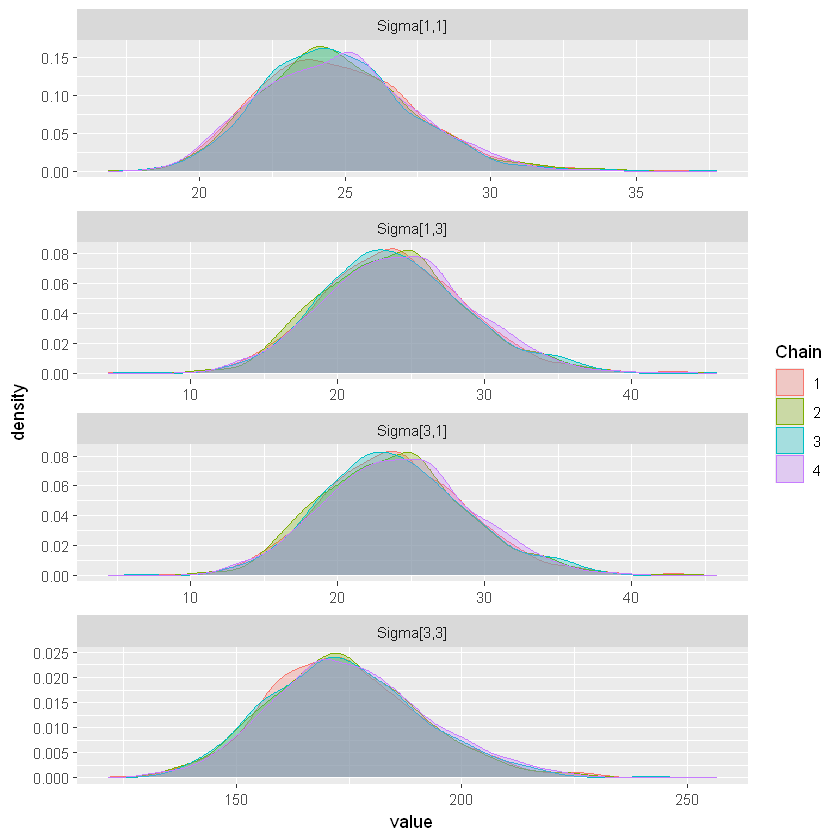

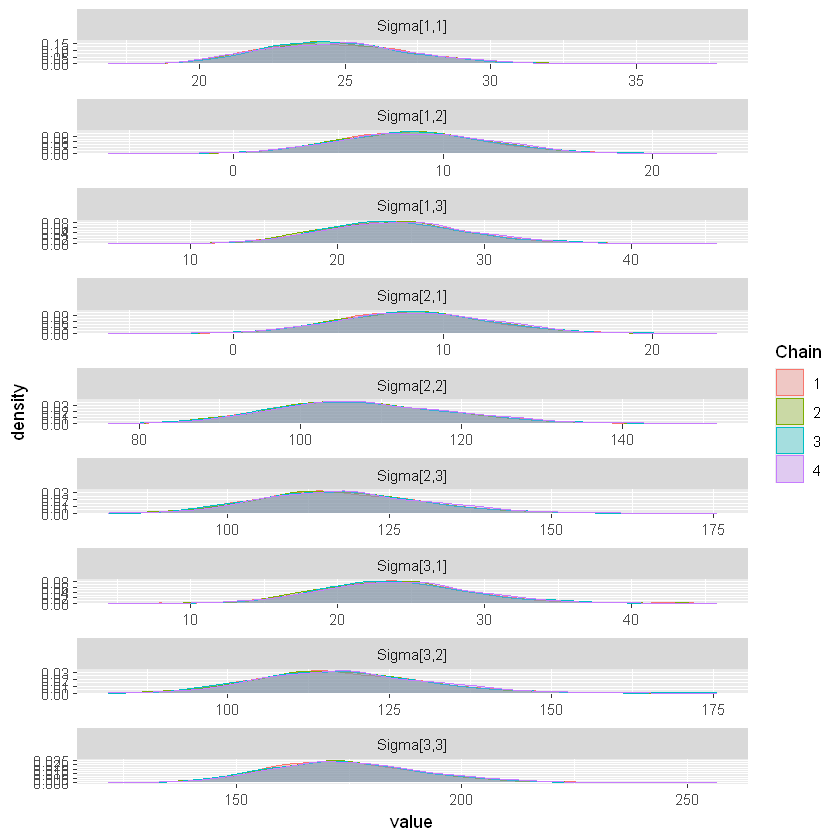

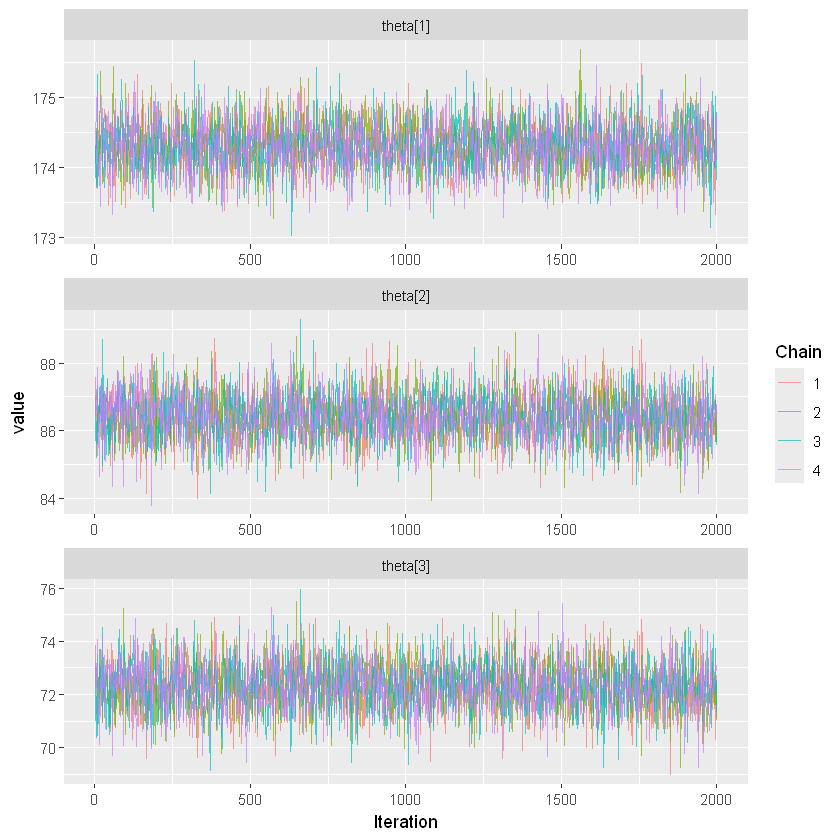

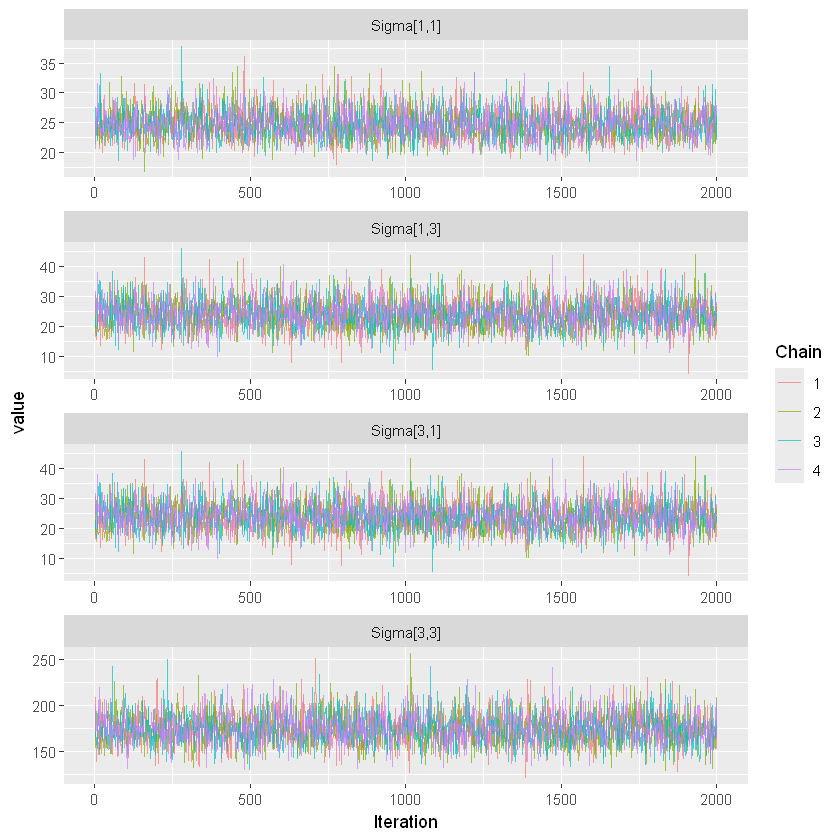

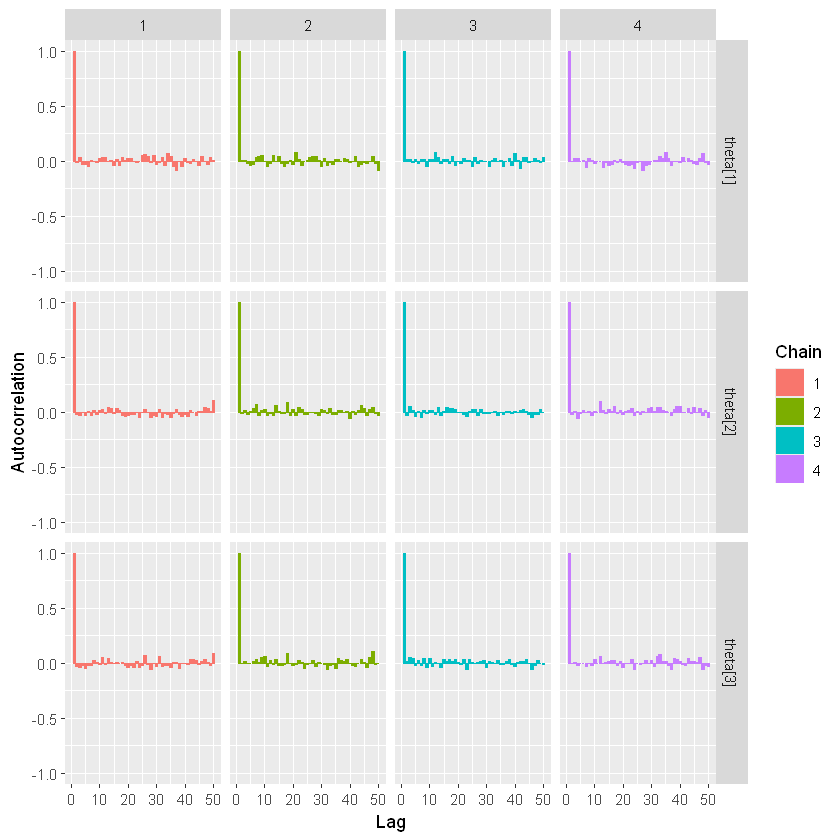

In [26]:
post %>% summary
post %>% ggs %>% ggs_density(family='theta')
post %>% ggs %>% ggs_density(family='Sigma')
post %>% ggs %>% ggs_density(family='Sigma\\[(1|3),(1|3)\\]')
post %>% ggs %>% ggs_density(family='Sigma\\[[1-3],[1-3]\\]')
post %>% ggs %>% ggs_traceplot(family='theta')
post %>% ggs %>% ggs_traceplot(family='Sigma\\[(1|3),(1|3)\\]')
post %>% ggs %>% ggs_autocorrelation(family='theta')